In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from tqdm import tqdm
from data import InMemoryFloodEventDataset
from utils import file_utils

In [2]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [3]:
mode = 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

dataset = InMemoryFloodEventDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_shp_file=dataset_parameters['nodes_shp_file'],
    edges_shp_file=dataset_parameters['edges_shp_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    spin_up_timesteps=dataset_parameters['spin_up_timesteps'],
    timesteps_from_peak=dataset_parameters['timesteps_from_peak'],
    inflow_boundary_edges=dataset_parameters['inflow_boundary_edges'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
)

Processing timesteps: 100%|██████████| 65059/65059 [00:11<00:00, 5624.33it/s]


In [4]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 4
Total number of timesteps: 65059


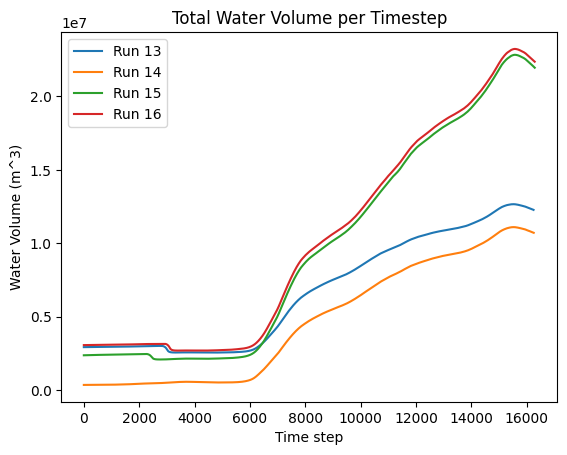

In [5]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_nodes_paths = dataset.processed_paths[3:(num_events + 3)]

for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes']
    water_volume_idx = InMemoryFloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    water_volume = dataset._denormalize('water_volume', water_volume)
    total_water_volume = water_volume.sum(axis=1)
    plt.plot(total_water_volume, label=f'Run {run_id}')

plt.title(f'Total Water Volume per Timestep')
plt.xlabel('Time step')
plt.ylabel('Water Volume (m^3)')
plt.legend()
plt.show()

In [6]:
FIRST_N_TIMESTEPS = 120

for run_id, start_idx in zip(dataset.hec_ras_run_ids, dataset.event_start_idx):
    print('Checking Run ID ', run_id)
    trimmed_dataset = dataset[start_idx:(start_idx+FIRST_N_TIMESTEPS)]
    for graph in tqdm(trimmed_dataset):
        non_boundary_edges_mask = ~np.isin(np.arange(graph.edge_index.shape[1]), graph.boundary_edges)
        non_boundary_edge_attr = graph.edge_attr[non_boundary_edges_mask, :]

        mid_edge_idx = non_boundary_edge_attr.shape[0] // 2
        num_dim_per_dynamic = (dataset.previous_timesteps + 1)
        num_dynamic_edge_dims = dataset.num_dynamic_edge_features * num_dim_per_dynamic
        first_half_edge_attr = non_boundary_edge_attr[:mid_edge_idx, -num_dynamic_edge_dims:]
        second_half_edge_attr = non_boundary_edge_attr[mid_edge_idx:, -num_dynamic_edge_dims:]

        for i, feat in enumerate(dataset.DYNAMIC_EDGE_FEATURES):
            feat_start_idx = i * num_dim_per_dynamic
            feat_end_idx = feat_start_idx + num_dim_per_dynamic
            first_half_feature = dataset._denormalize(feat, first_half_edge_attr[:, feat_start_idx:feat_end_idx])
            second_half_feature = dataset._denormalize(feat, second_half_edge_attr[:, feat_start_idx:feat_end_idx])

            # Use allclose due to potential floating point precision issues
            assert torch.allclose(first_half_feature, -second_half_feature, atol=1e-5),\
                "Dynamic edge attributes must be opposite in the two halves."

Checking Run ID  13


100%|██████████| 120/120 [00:00<00:00, 2161.60it/s]


Checking Run ID  14


100%|██████████| 120/120 [00:00<00:00, 2107.74it/s]


Checking Run ID  15


100%|██████████| 120/120 [00:00<00:00, 2216.90it/s]


Checking Run ID  16


100%|██████████| 120/120 [00:00<00:00, 2301.71it/s]


Nodes with the highest water volume difference:
[1022, 1023, 1026, 1082]
Node 1022: 164292.17 m
Node 1023: 158217.25 m
Node 1026: 155777.58 m
Node 1082: 141427.00 m


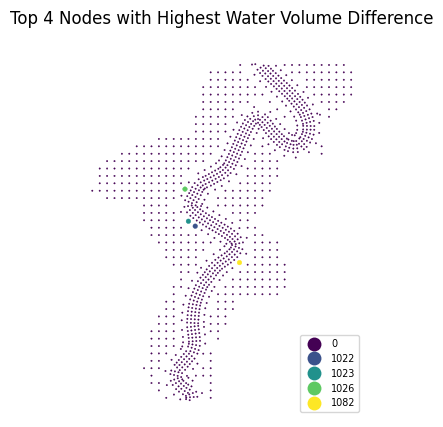

In [ ]:
def get_highest_diff_water_volume_nodes(dataset: InMemoryFloodEventDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_nodes_paths = dataset.processed_paths[3:(num_events + 3)]

    dynamic_nodes = np.load(dynamic_nodes_paths[event_idx])['dynamic_nodes']
    water_volume_idx = InMemoryFloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    water_volume = dataset._denormalize('water_volume', water_volume)
    wv_diff = np.abs(np.diff(water_volume, axis=0))
    wv_diff_per_node = wv_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wv_diff_per_node)[-k:][::-1].tolist()
    top_k_wd_diff = wv_diff_per_node[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff

def get_node_df(dataset: InMemoryFloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
    nodes_shp_path = dataset.raw_paths[0]
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        ghost_nodes = dataset._get_ghost_nodes()
        node_df = node_df[~node_df['CC_index'].isin(ghost_nodes)]

    return node_df

def plot_cell_map(node_df: gpd.GeoDataFrame, value: np.ndarray=None, cmap=None):
    default_marker_size = 1
    shared_plot_kwargs = {
        'linewidth': 0.3,
        'markersize': default_marker_size,
    }

    if value is not None:
        value_column = 'is_flooded'
        node_df[value_column] = value
        if cmap is None:
            cmap = plt.get_cmap('seismic_r') 
        markersize = (value.astype(bool).astype(int) * 10) + default_marker_size
        shared_plot_kwargs.update({
            'markersize': markersize,
            'cmap': cmap,
            'column': value_column,
            'legend': True,
            'legend_kwds': {
                'loc': 'lower right',
                'fontsize': 'x-small',
            },
        })

    node_df.plot(**shared_plot_kwargs)
    plt.axis('off')

EVENT_IDX = 0  # Change this to the desired event index
k = 4  # Number of top nodes to retrieve

top_k_diff_idx, top_k_wd_diff = get_highest_diff_water_volume_nodes(dataset, EVENT_IDX, k=k)
print('Nodes with the highest water volume difference:')
print(top_k_diff_idx)
for idx, wd in zip(top_k_diff_idx, top_k_wd_diff):
    print(f"Node {idx}: {wd:.2f} m")

node_df = get_node_df(dataset)
highlight = np.zeros(len(node_df), dtype=object)
highlight[top_k_diff_idx] = top_k_diff_idx

plot_cell_map(node_df, value=highlight, cmap='viridis')
plt.title(f'Top {k} Nodes with Highest Water Volume Difference')
plt.show()